@inproceedings{souza2020bertimbau, author = {F{'a}bio Souza and Rodrigo Nogueira and Roberto Lotufo}, title = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese}, booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)}, year = {2020} }

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nbstripout
!nbstripout /content/drive/MyDrive/2025/tcc-final/fine_tuning_Bertimbau_version2_24_07.ipynb

Could not strip '/content/drive/MyDrive/2025/tcc-final/fine_tuning_Bertimbau_version2_24_07.ipynb': file not found


In [3]:
!pip install transformers evaluate accelerate
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback # Importa explicitamente para o callback
)
import torch
from torch.utils.data import Dataset as TorchDataset
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import subprocess
import time
import evaluate
start_total_time = time.time()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00


# **1. Preparação do Dataset para K-Fold**

Iniciamos carregando o dataset completo de denúncias. Diferente do método anterior, aqui não faremos uma divisão fixa. Em vez disso, usaremos a ***técnica de Validação Cruzada (K-Fold)***, que nos permite treinar e validar o modelo várias vezes em subconjuntos diferentes do nosso dataset, obtendo uma avaliação de desempenho mais confiável e robusta.

In [4]:
# Carregar dataset já processado
file_path = '/content/drive/MyDrive/2025/tcc-final/denuncias_balanceadas.xlsx'
df = pd.read_excel(file_path)

print(f"Dataset carregado. Total de registros: {len(df)}")
print("Primeiras 5 linhas do dataset:")
print(df.head())
print("\nInformações do dataset:")
print(df.info())

Dataset carregado. Total de registros: 169
Primeiras 5 linhas do dataset:
                                               texto             classe
0  Segundo informações da [VÍTIMA], na sexta, a m...  invasao_domicilio
1  Policiais arrombaram a casa, quebraram sapatei...  invasao_domicilio
2  [VÍTIMA] relata que sua vizinha [VÍTIMA] teve ...  invasao_domicilio
3  [VÍTIMA] relata que abriram o portão de sua ca...  invasao_domicilio
4  [VÍTIMA] teve a casa invadida por policiais do...  invasao_domicilio

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   169 non-null    object
 1   classe  169 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB
None


# **2. Processando o Texto com o BERTimbau**

Assim como na abordagem anterior, esta etapa é crucial para preparar o texto. Usamos o ***tokenizer*** do modelo ***BERTimbau*** para converter as denúncias em um formato numérico compreensível pelo modelo. Também criamos classes personalizadas ***(CustomDataset)*** e um *** DataCollator*** para otimizar a forma como os dados são alimentados ao modelo durante o treinamento e a avaliação.


In [5]:
model_path = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize_function(batch):
    return tokenizer(batch["texto"], truncation=True, max_length=512, padding='longest', return_tensors='pt')

# Mapeamento de Labels: Essencial para o modelo e métricas
id2label = {0: "invasao_domicilio", 1: "violencia_fisica"}
label2id = {v: k for k, v in id2label.items()}

# Custom Dataset (para trabalhar com tensores PyTorch diretamente)
class CustomDataset(TorchDataset): # Certifique-se que 'Dataset' foi importado corretamente
    def __init__(self, encodings, labels):
        self.encodings = encodings # Agora será um dicionário de tensores (input_ids, attention_mask)
        self.labels = labels       # Agora será uma lista de labels (ou Series com índice reiniciado)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long) # Acesso direto pelo índice
        return item

    def __len__(self):
        return len(self.labels)

# Data Collator para padding dinâmico durante o treinamento
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# **3. Métricas de Desempenho**

Para avaliar o desempenho do nosso modelo de forma completa, definimos uma série de métricas. Além da ***acurácia*** (a proporção de acertos), calculamos o ***AUC-ROC*** (que mede a capacidade de distinção entre as classes), e as métricas de ***Precisão, Recall e F1-Score***. O cálculo dessas métricas para cada classe e a média (***macro***) nos dão uma visão detalhada do desempenho do modelo, especialmente em datasets com classes desbalanceadas.

In [6]:
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")
auc_metric = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    try:
        predictions, labels = eval_pred
        probabilities = np.exp(predictions - np.max(predictions, axis=-1, keepdims=True)) / np.sum(np.exp(predictions - np.max(predictions, axis=-1, keepdims=True)), axis=-1, keepdims=True)
        positive_class_probs = probabilities[:, 1]

        # Classe prevista (ID da maior probabilidade)
        preds = np.argmax(predictions, axis=1)

        # Labels das classes, conforme definido no notebook
        class_labels = [label2id["invasao_domicilio"], label2id["violencia_fisica"]]

        # --- CÁLCULO DAS MÉTRICAS ---
        acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
        auc = auc_metric.compute(prediction_scores=positive_class_probs, references=labels)["roc_auc"]

        f1_results_by_class = f1_metric.compute(predictions=preds, references=labels, average=None, labels=class_labels)["f1"]
        f1_macro = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]

        precision_results_by_class = precision_metric.compute(predictions=preds, references=labels, average=None, labels=class_labels)["precision"]
        precision_macro = precision_metric.compute(predictions=preds, references=labels, average="macro")["precision"]

        recall_results_by_class = recall_metric.compute(predictions=preds, references=labels, average=None, labels=class_labels)["recall"]
        recall_macro = recall_metric.compute(predictions=preds, references=labels, average="macro")["recall"]

        # --- RETORNO DO DICIONÁRIO COMPLETO DE MÉTRICAS ---
        return {
            "accuracy": round(acc, 4),
            "auc": round(auc, 4),
            "f1_invasao": round(f1_results_by_class[0], 4),
            "f1_violencia": round(f1_results_by_class[1], 4),
            "precision_invasao": round(precision_results_by_class[0], 4),
            "precision_violencia": round(precision_results_by_class[1], 4),
            "recall_invasao": round(recall_results_by_class[0], 4),
            "recall_violencia": round(recall_results_by_class[1], 4),
            "precision_macro": round(precision_macro, 4),
            "recall_macro": round(recall_macro, 4),
            "f1_macro": round(f1_macro, 4)
        }
    except Exception as e:
        print(f"Erro no cálculo de métricas: {str(e)}")
        # Em caso de erro, retorna valores padrão para não quebrar o treinamento
        return {
            "accuracy": 0.0,
            "auc": 0.0,
            "f1_invasao": 0.0,
            "f1_violencia": 0.0,
            "precision_invasao": 0.0,
            "precision_violencia": 0.0,
            "recall_invasao": 0.0,
            "recall_violencia": 0.0,
            "precision_macro": 0.0,
            "recall_macro": 0.0,
            "f1_macro": 0.0
        }

# **4. Validação Cruzada (K-Fold) com Early Stopping**

Esta é a etapa central do nosso projeto. Utilizamos a ***Validação Cruzada com 5 folds*** para treinar o modelo. Isso significa que o dataset é dividido em 5 partes: o modelo é treinado em 4 delas e validado na 5ª. Este processo se repete 5 vezes, garantindo que todas as denúncias sejam usadas na validação e nos dando uma estimativa mais precisa do desempenho geral do modelo. O ***Early Stopping*** é uma ferramenta crucial para evitar o overfitting, interrompendo o treinamento se o modelo parar de melhorar.


🚀 Iniciando Treinamento com K-Fold Cross-Validation (5 folds)....


==================== INICIANDO FOLD 1/5 ====================


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Número de parâmetros treináveis no FOLD 1: 592130


Epoch,Training Loss,Validation Loss,Accuracy,Auc,F1 Invasao,F1 Violencia,Precision Invasao,Precision Violencia,Recall Invasao,Recall Violencia,Precision Macro,Recall Macro,F1 Macro
1,0.693600,0.659984,0.617600,0.813100,0.518500,0.682900,0.700000,0.583300,0.411800,0.823500,0.641700,0.617600,0.600700
2,0.654000,0.627571,0.735300,0.833900,0.727300,0.742900,0.750000,0.722200,0.705900,0.764700,0.736100,0.735300,0.735100
3,0.578900,0.599056,0.735300,0.840800,0.709700,0.756800,0.785700,0.700000,0.647100,0.823500,0.742900,0.735300,0.733200
4,0.573500,0.577777,0.764700,0.854700,0.750000,0.777800,0.800000,0.736800,0.705900,0.823500,0.768400,0.764700,0.763900
5,0.551500,0.558109,0.764700,0.840800,0.750000,0.777800,0.800000,0.736800,0.705900,0.823500,0.768400,0.764700,0.763900
6,0.512800,0.540086,0.794100,0.854700,0.787900,0.800000,0.812500,0.777800,0.764700,0.823500,0.795100,0.794100,0.793900
7,0.516800,0.524831,0.794100,0.865100,0.787900,0.800000,0.812500,0.777800,0.764700,0.823500,0.795100,0.794100,0.793900
8,0.505600,0.511241,0.764700,0.875400,0.733300,0.789500,0.846200,0.714300,0.647100,0.882400,0.780200,0.764700,0.761400
9,0.461700,0.488125,0.794100,0.882400,0.787900,0.800000,0.812500,0.777800,0.764700,0.823500,0.795100,0.794100,0.793900
10,0.455500,0.477259,0.794100,0.878900,0.787900,0.800000,0.812500,0.777800,0.764700,0.823500,0.795100,0.794100,0.793900


✅ Modelo salvo em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold-1


✅ Previsões salvas em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold_1_predictions.xlsx
📊 Métricas finais de treino para FOLD 1:
Loss: 0.4390
Tempo total: 154.28s
🧪 Avaliação no conjunto de teste/validação do FOLD 1...


Resultados do FOLD 1: {'eval_loss': 0.3940317630767822, 'eval_accuracy': 0.8235, 'eval_auc': 0.9031, 'eval_f1_invasao': 0.8125, 'eval_f1_violencia': 0.8333, 'eval_precision_invasao': 0.8667, 'eval_precision_violencia': 0.7895, 'eval_recall_invasao': 0.7647, 'eval_recall_violencia': 0.8824, 'eval_precision_macro': 0.8281, 'eval_recall_macro': 0.8235, 'eval_f1_macro': 0.8229, 'eval_runtime': 0.2692, 'eval_samples_per_second': 126.298, 'eval_steps_per_second': 18.573, 'epoch': 25.0}

==================== INICIANDO FOLD 2/5 ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Número de parâmetros treináveis no FOLD 2: 592130


Epoch,Training Loss,Validation Loss,Accuracy,Auc,F1 Invasao,F1 Violencia,Precision Invasao,Precision Violencia,Recall Invasao,Recall Violencia,Precision Macro,Recall Macro,F1 Macro
1,0.688400,0.645307,0.735300,0.861600,0.666700,0.780500,0.900000,0.666700,0.529400,0.941200,0.783300,0.735300,0.723600
2,0.645600,0.611974,0.794100,0.882400,0.787900,0.800000,0.812500,0.777800,0.764700,0.823500,0.795100,0.794100,0.793900
3,0.608100,0.579863,0.794100,0.910000,0.787900,0.800000,0.812500,0.777800,0.764700,0.823500,0.795100,0.794100,0.793900
4,0.569800,0.551000,0.764700,0.906600,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700
5,0.553200,0.524619,0.823500,0.910000,0.812500,0.833300,0.866700,0.789500,0.764700,0.882400,0.828100,0.823500,0.822900
6,0.522100,0.506211,0.823500,0.906600,0.812500,0.833300,0.866700,0.789500,0.764700,0.882400,0.828100,0.823500,0.822900
7,0.507700,0.488303,0.823500,0.910000,0.812500,0.833300,0.866700,0.789500,0.764700,0.882400,0.828100,0.823500,0.822900
8,0.483300,0.479417,0.823500,0.910000,0.800000,0.842100,0.923100,0.761900,0.705900,0.941200,0.842500,0.823500,0.821100
9,0.466900,0.467648,0.823500,0.913500,0.800000,0.842100,0.923100,0.761900,0.705900,0.941200,0.842500,0.823500,0.821100
10,0.444700,0.456742,0.852900,0.920400,0.838700,0.864900,0.928600,0.800000,0.764700,0.941200,0.864300,0.852900,0.851800


✅ Modelo salvo em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold-2


✅ Previsões salvas em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold_2_predictions.xlsx
📊 Métricas finais de treino para FOLD 2:
Loss: 0.4253
Tempo total: 221.14s
🧪 Avaliação no conjunto de teste/validação do FOLD 2...


Resultados do FOLD 2: {'eval_loss': 0.36877262592315674, 'eval_accuracy': 0.8529, 'eval_auc': 0.9377, 'eval_f1_invasao': 0.8387, 'eval_f1_violencia': 0.8649, 'eval_precision_invasao': 0.9286, 'eval_precision_violencia': 0.8, 'eval_recall_invasao': 0.7647, 'eval_recall_violencia': 0.9412, 'eval_precision_macro': 0.8643, 'eval_recall_macro': 0.8529, 'eval_f1_macro': 0.8518, 'eval_runtime': 0.244, 'eval_samples_per_second': 139.335, 'eval_steps_per_second': 20.49, 'epoch': 29.0}

==================== INICIANDO FOLD 3/5 ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Número de parâmetros treináveis no FOLD 3: 592130


Epoch,Training Loss,Validation Loss,Accuracy,Auc,F1 Invasao,F1 Violencia,Precision Invasao,Precision Violencia,Recall Invasao,Recall Violencia,Precision Macro,Recall Macro,F1 Macro
1,0.695900,0.655065,0.588200,0.809700,0.416700,0.681800,0.714300,0.555600,0.294100,0.882400,0.634900,0.588200,0.549200
2,0.625600,0.627161,0.794100,0.795800,0.774200,0.810800,0.857100,0.750000,0.705900,0.882400,0.803600,0.794100,0.792500
3,0.580800,0.607264,0.794100,0.799300,0.774200,0.810800,0.857100,0.750000,0.705900,0.882400,0.803600,0.794100,0.792500
4,0.558600,0.593520,0.764700,0.806200,0.750000,0.777800,0.800000,0.736800,0.705900,0.823500,0.768400,0.764700,0.763900
5,0.561000,0.580247,0.764700,0.813100,0.750000,0.777800,0.800000,0.736800,0.705900,0.823500,0.768400,0.764700,0.763900
6,0.518200,0.570478,0.735300,0.809700,0.709700,0.756800,0.785700,0.700000,0.647100,0.823500,0.742900,0.735300,0.733200
7,0.488600,0.561857,0.764700,0.813100,0.750000,0.777800,0.800000,0.736800,0.705900,0.823500,0.768400,0.764700,0.763900
8,0.431600,0.555829,0.735300,0.809700,0.709700,0.756800,0.785700,0.700000,0.647100,0.823500,0.742900,0.735300,0.733200
9,0.459100,0.547633,0.764700,0.806200,0.750000,0.777800,0.800000,0.736800,0.705900,0.823500,0.768400,0.764700,0.763900
10,0.435600,0.543799,0.764700,0.809700,0.750000,0.777800,0.800000,0.736800,0.705900,0.823500,0.768400,0.764700,0.763900


✅ Modelo salvo em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold-3


✅ Previsões salvas em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold_3_predictions.xlsx
📊 Métricas finais de treino para FOLD 3:
Loss: 0.4083
Tempo total: 199.38s
🧪 Avaliação no conjunto de teste/validação do FOLD 3...


Resultados do FOLD 3: {'eval_loss': 0.5001969933509827, 'eval_accuracy': 0.7353, 'eval_auc': 0.8408, 'eval_f1_invasao': 0.7097, 'eval_f1_violencia': 0.7568, 'eval_precision_invasao': 0.7857, 'eval_precision_violencia': 0.7, 'eval_recall_invasao': 0.6471, 'eval_recall_violencia': 0.8235, 'eval_precision_macro': 0.7429, 'eval_recall_macro': 0.7353, 'eval_f1_macro': 0.7332, 'eval_runtime': 0.3092, 'eval_samples_per_second': 109.967, 'eval_steps_per_second': 16.172, 'epoch': 29.0}

==================== INICIANDO FOLD 4/5 ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Número de parâmetros treináveis no FOLD 4: 592130


Epoch,Training Loss,Validation Loss,Accuracy,Auc,F1 Invasao,F1 Violencia,Precision Invasao,Precision Violencia,Recall Invasao,Recall Violencia,Precision Macro,Recall Macro,F1 Macro
1,0.695400,0.641013,0.676500,0.865100,0.560000,0.744200,0.875000,0.615400,0.411800,0.941200,0.745200,0.676500,0.652100
2,0.633700,0.610969,0.764700,0.847800,0.777800,0.750000,0.736800,0.800000,0.823500,0.705900,0.768400,0.764700,0.763900
3,0.594100,0.581263,0.794100,0.851200,0.787900,0.800000,0.812500,0.777800,0.764700,0.823500,0.795100,0.794100,0.793900
4,0.597300,0.563922,0.705900,0.868500,0.722200,0.687500,0.684200,0.733300,0.764700,0.647100,0.708800,0.705900,0.704900
5,0.525200,0.544326,0.764700,0.868500,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700
6,0.513200,0.528112,0.764700,0.872000,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700,0.764700
7,0.498300,0.508053,0.823500,0.889300,0.812500,0.833300,0.866700,0.789500,0.764700,0.882400,0.828100,0.823500,0.822900
8,0.445600,0.491091,0.852900,0.899700,0.838700,0.864900,0.928600,0.800000,0.764700,0.941200,0.864300,0.852900,0.851800
9,0.464900,0.477498,0.852900,0.903100,0.838700,0.864900,0.928600,0.800000,0.764700,0.941200,0.864300,0.852900,0.851800
10,0.472900,0.467946,0.852900,0.903100,0.838700,0.864900,0.928600,0.800000,0.764700,0.941200,0.864300,0.852900,0.851800


✅ Modelo salvo em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold-4


✅ Previsões salvas em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold_4_predictions.xlsx
📊 Métricas finais de treino para FOLD 4:
Loss: 0.4165
Tempo total: 194.34s
🧪 Avaliação no conjunto de teste/validação do FOLD 4...


Resultados do FOLD 4: {'eval_loss': 0.37114760279655457, 'eval_accuracy': 0.9412, 'eval_auc': 0.9308, 'eval_f1_invasao': 0.9375, 'eval_f1_violencia': 0.9444, 'eval_precision_invasao': 1.0, 'eval_precision_violencia': 0.8947, 'eval_recall_invasao': 0.8824, 'eval_recall_violencia': 1.0, 'eval_precision_macro': 0.9474, 'eval_recall_macro': 0.9412, 'eval_f1_macro': 0.941, 'eval_runtime': 0.2979, 'eval_samples_per_second': 114.144, 'eval_steps_per_second': 16.786, 'epoch': 30.0}

==================== INICIANDO FOLD 5/5 ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Número de parâmetros treináveis no FOLD 5: 592130


Epoch,Training Loss,Validation Loss,Accuracy,Auc,F1 Invasao,F1 Violencia,Precision Invasao,Precision Violencia,Recall Invasao,Recall Violencia,Precision Macro,Recall Macro,F1 Macro
1,0.691100,0.653365,0.697000,0.797800,0.642900,0.736800,0.750000,0.666700,0.562500,0.823500,0.708300,0.693000,0.689800
2,0.631400,0.630031,0.787900,0.794100,0.787900,0.787900,0.764700,0.812500,0.812500,0.764700,0.788600,0.788600,0.787900
3,0.602300,0.608717,0.697000,0.794100,0.666700,0.722200,0.714300,0.684200,0.625000,0.764700,0.699200,0.694900,0.694400
4,0.531600,0.591675,0.818200,0.801500,0.823500,0.812500,0.777800,0.866700,0.875000,0.764700,0.822200,0.819900,0.818000
5,0.544900,0.574485,0.787900,0.812500,0.787900,0.787900,0.764700,0.812500,0.812500,0.764700,0.788600,0.788600,0.787900
6,0.504000,0.556389,0.757600,0.819900,0.750000,0.764700,0.750000,0.764700,0.750000,0.764700,0.757400,0.757400,0.757400
7,0.457000,0.542821,0.757600,0.823500,0.750000,0.764700,0.750000,0.764700,0.750000,0.764700,0.757400,0.757400,0.757400
8,0.493400,0.529012,0.727300,0.838200,0.709700,0.742900,0.733300,0.722200,0.687500,0.764700,0.727800,0.726100,0.726300
9,0.469900,0.515608,0.757600,0.845600,0.750000,0.764700,0.750000,0.764700,0.750000,0.764700,0.757400,0.757400,0.757400
10,0.477800,0.509259,0.818200,0.864000,0.823500,0.812500,0.777800,0.866700,0.875000,0.764700,0.822200,0.819900,0.818000


✅ Modelo salvo em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold-5


✅ Previsões salvas em: /content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold_5_predictions.xlsx
📊 Métricas finais de treino para FOLD 5:
Loss: 0.4181
Tempo total: 200.04s
🧪 Avaliação no conjunto de teste/validação do FOLD 5...


Resultados do FOLD 5: {'eval_loss': 0.4245337247848511, 'eval_accuracy': 0.7879, 'eval_auc': 0.9007, 'eval_f1_invasao': 0.7879, 'eval_f1_violencia': 0.7879, 'eval_precision_invasao': 0.7647, 'eval_precision_violencia': 0.8125, 'eval_recall_invasao': 0.8125, 'eval_recall_violencia': 0.7647, 'eval_precision_macro': 0.7886, 'eval_recall_macro': 0.7886, 'eval_f1_macro': 0.7879, 'eval_runtime': 0.3038, 'eval_samples_per_second': 108.638, 'eval_steps_per_second': 16.46, 'epoch': 30.0}


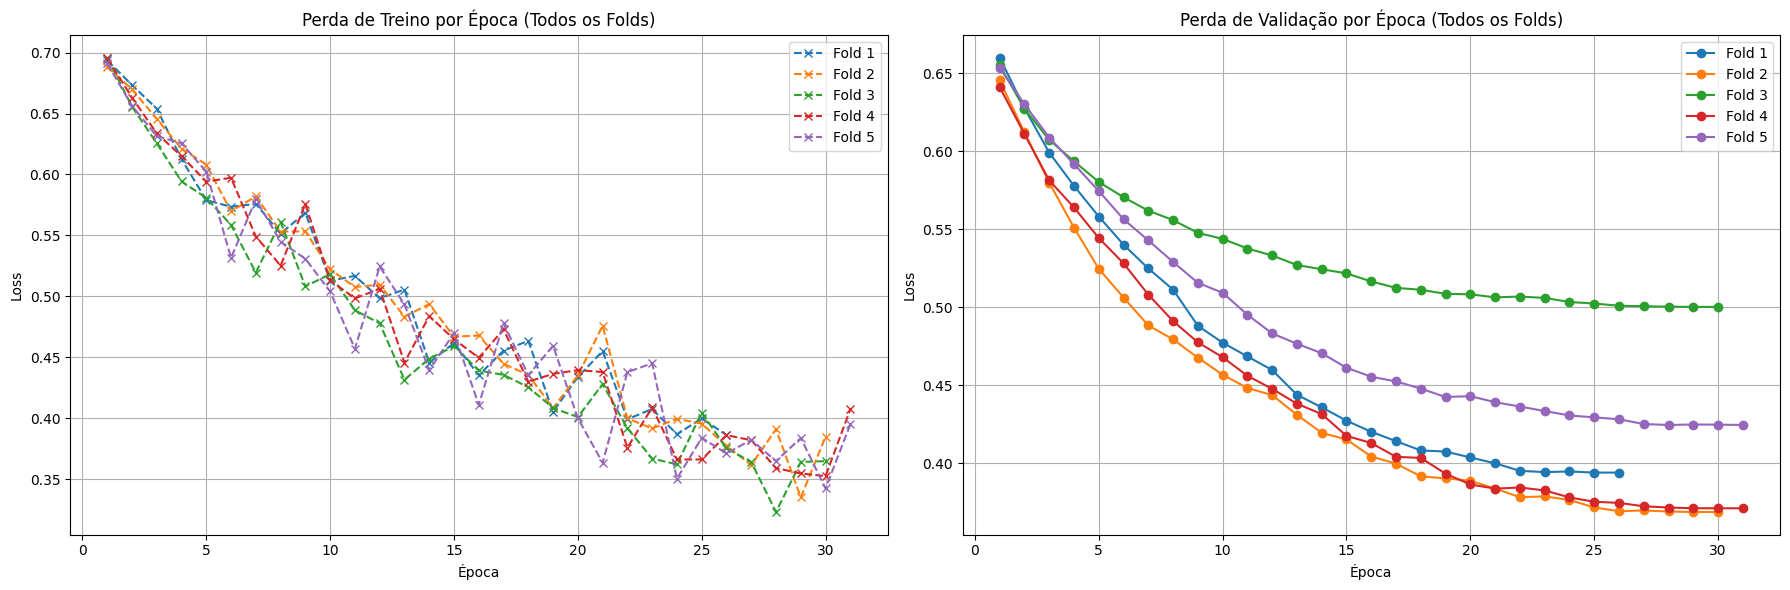

In [7]:
# Essas listas armazenarão o histórico de métricas de CADA fold para a plotagem.
all_fold_train_losses = []
all_fold_eval_losses = []
all_fold_eval_accuracies = []
# ---------------------------------------------------------------------

# Parâmetros de Treinamento
training_args = TrainingArguments(
    output_dir="./bertimbau-denuncias-cv", # Diretório de saída para K-Fold
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=30, # Aumentado para permitir que Early Stopping atue
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", # Monitorar a perda de validação
    greater_is_better=False, # Menor perda é melhor
    logging_dir="./logs-cv",
    logging_steps=10, # Diminuído para ver logs mais frequentemente (era 100)
    disable_tqdm=False,
    report_to="none",
    fp16=True, # Treinamento com precisão mista
    seed=42, # Semente para reprodutibilidade
    gradient_accumulation_steps=1,
    remove_unused_columns=True,
    label_names=["labels"]
)

# Preparar dados para K-Fold
all_texts = df['texto'].tolist()
all_labels_mapped = df['classe'].map(label2id).tolist() # Labels já mapeadas para IDs numéricos

N_SPLITS = 5 # Número de folds. Para 150 registros, 5 folds é razoável.
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Lista para armazenar as métricas de teste de cada fold
all_fold_test_metrics = []

print(f"\n🚀 Iniciando Treinamento com K-Fold Cross-Validation ({N_SPLITS} folds)....\n")

# Loop através dos folds
for fold, (train_index, test_index) in enumerate(skf.split(all_texts, all_labels_mapped)):
    print(f"\n==================== INICIANDO FOLD {fold+1}/{N_SPLITS} ====================")

    # Dividir os dados para o fold atual
    train_fold_texts = [all_texts[i] for i in train_index]
    train_fold_labels = [all_labels_mapped[i] for i in train_index]
    test_fold_texts = [all_texts[i] for i in test_index]
    test_fold_labels = [all_labels_mapped[i] for i in test_index]

    # Tokenizar os dados para o fold atual
    train_fold_encodings = tokenize_function({"texto": train_fold_texts})
    test_fold_encodings = tokenize_function({"texto": test_fold_texts})

    # Criar CustomDatasets para o fold atual
    train_dataset = CustomDataset(train_fold_encodings, train_fold_labels)
    eval_dataset_for_trainer = CustomDataset(test_fold_encodings, test_fold_labels)

    # Re-instanciar o modelo para cada fold para garantir pesos iniciais limpos
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=2,
        id2label=id2label,
        label2id=label2id
    )

    # Congelar camadas do BERT (exceto pooler e classificador)
    for name, param in model.named_parameters():
        if 'classifier' not in name and 'pooler' not in name:
            param.requires_grad = False

    print(f"  Número de parâmetros treináveis no FOLD {fold+1}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    # Re-instanciar o Trainer para cada fold
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset_for_trainer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold = 1e-3)],
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Treinar o modelo para o fold atual
    try:
        train_result = trainer.train()

        # Salvar o best model do fold atual
        output_dir_fold = f"/content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold-{fold+1}"
        trainer.save_model(output_dir_fold)
        print(f"✅ Modelo salvo em: {output_dir_fold}")

        # Perform evaluation on the test set of the current fold
        evaluation_output = trainer.evaluate(eval_dataset_for_trainer)

        # Extract predictions and true labels
        predictions = trainer.predict(eval_dataset_for_trainer).predictions
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = eval_dataset_for_trainer.labels

        # Map predicted labels back to original class names
        predicted_class_names = [id2label[label] for label in predicted_labels]
        true_class_names = [id2label[label] for label in true_labels]

        # Create a DataFrame with text, true labels, and predicted labels
        predictions_df = pd.DataFrame({
            "texto": test_fold_texts,
            "classe_verdadeira": true_class_names,
            "classe_prevista": predicted_class_names
        })

        # Save the DataFrame to an Excel file
        predictions_output_path = f"/content/drive/MyDrive/2025/tcc-final/resultados_kfold/fold_{fold+1}_predictions.xlsx"
        predictions_df.to_excel(predictions_output_path, index=False)
        print(f"✅ Previsões salvas em: {predictions_output_path}")


        # --- NOVA LÓGICA DE COLETA DE MÉTRICAS PARA PLOTAGEM ---
        # Extrair o histórico de logs do Trainer para o fold atual
        logs = trainer.state.log_history

        # Listas temporárias para as métricas deste fold
        fold_train_losses, fold_eval_losses, fold_eval_accuracies = [], [], []

        for log_entry in logs:
            if 'loss' in log_entry and 'eval_loss' not in log_entry:
                fold_train_losses.append(log_entry['loss'])
            if 'eval_loss' in log_entry:
                fold_eval_losses.append(log_entry['eval_loss'])
                fold_eval_accuracies.append(log_entry['eval_accuracy'])

        # Armazenar as curvas de métricas deste fold nas listas globais
        all_fold_train_losses.append(fold_train_losses)
        all_fold_eval_losses.append(fold_eval_losses)
        all_fold_eval_accuracies.append(fold_eval_accuracies)
        # --------------------------------------------------------

        print(f"📊 Métricas finais de treino para FOLD {fold+1}:")
        print(f"Loss: {train_result.metrics.get('train_loss', 'N/A'):.4f}")
        print(f"Tempo total: {train_result.metrics.get('train_runtime', 'N/A'):.2f}s")

        # Evaluate on the test/validation set of the fold
        print(f"🧪 Avaliação no conjunto de teste/validação do FOLD {fold+1}...")
        fold_test_metrics = trainer.evaluate(eval_dataset_for_trainer)
        all_fold_test_metrics.append(fold_test_metrics)
        print(f"Resultados do FOLD {fold+1}: {fold_test_metrics}")

    except Exception as e:
        import traceback
        print(f"❌ Erro durante o treinamento do FOLD {fold+1}:")
        print(traceback.format_exc())
        all_fold_test_metrics.append({
            'eval_loss': float('nan'),
            'eval_accuracy': 0.0,
            'eval_auc': 0.0,
            'eval_f1_invasao': 0.0,
            'eval_f1_violencia': 0.0,
            'eval_runtime': float('nan'),
            'eval_samples_per_second': 0.0,
            'eval_steps_per_second': 0.0
        })

# --- CÓDIGO DE PLOTAGEM AJUSTADO PARA K-FOLD ---

max_epochs = max(len(h) for h in all_fold_eval_losses)
epochs = list(range(1, max_epochs + 1))

# Criar a figura com dois subplots (1 linha, 2 colunas)
# Aumentamos o tamanho para melhor visualização.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

for i, train_loss_history in enumerate(all_fold_train_losses):
    ax1.plot(range(1, len(all_fold_eval_losses[i]) + 1),
             all_fold_train_losses[i][:len(all_fold_eval_losses[i])],
             marker='x', linestyle='--', label=f'Fold {i+1}')

ax1.set_xlabel("Época")
ax1.set_ylabel("Loss")
ax1.set_title("Perda de Treino por Época (Todos os Folds)")
ax1.legend()
ax1.grid(True)

# --- Gráfico 2: Perda de Validação por Época ---
# Este gráfico já estava correto, agora com a escala do eixo X ajustada
for i, eval_loss_history in enumerate(all_fold_eval_losses):
    ax2.plot(range(1, len(eval_loss_history) + 1), eval_loss_history, marker='o', linestyle='-', label=f'Fold {i+1}')

ax2.set_xlabel("Época")
ax2.set_ylabel("Loss")
ax2.set_title("Perda de Validação por Época (Todos os Folds)")
ax2.legend()
ax2.grid(True)

# Ajusta o layout para evitar sobreposição de títulos e rótulos
plt.tight_layout()
plt.show()

# **5. RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA**

In [8]:
print("\n\n==================== RESULTADOS FINAIS K-FOLD CROSS-VALIDATION ====================")

if all_fold_test_metrics:
    # Coletar todas as métricas de todos os folds
    df_metrics = pd.DataFrame(all_fold_test_metrics)

    # Calcular médias e desvios padrão
    avg_metrics = df_metrics.mean(numeric_only=True).round(4).to_dict()
    std_metrics = df_metrics.std(numeric_only=True).round(4).to_dict()

    print("Métricas Médias (e Desvio Padrão) em todos os Folds:")
    for metric, avg_value in avg_metrics.items():
        # Excluir métricas de tempo/desempenho por segundo da apresentação principal se desejar
        if 'runtime' not in metric and 'samples_per_second' not in metric and 'steps_per_second' not in metric:
            print(f"{metric}: {avg_value} (± {std_metrics.get(metric, 0)})")
else:
    print("Nenhum resultado de fold foi coletado. Ocorreram erros em todos os folds.")

print("\n✅ K-Fold Cross-Validation Concluído.")



==================== RESULTADOS FINAIS K-FOLD CROSS-VALIDATION ====================
Métricas Médias (e Desvio Padrão) em todos os Folds:
eval_loss: 0.4117 (± 0.0543)
eval_accuracy: 0.8282 (± 0.0769)
eval_auc: 0.9026 (± 0.0382)
eval_f1_invasao: 0.8173 (± 0.0827)
eval_f1_violencia: 0.8375 (± 0.0727)
eval_precision_invasao: 0.8691 (± 0.0982)
eval_precision_violencia: 0.7993 (± 0.0693)
eval_recall_invasao: 0.7743 (± 0.0859)
eval_recall_violencia: 0.8824 (± 0.093)
eval_precision_macro: 0.8343 (± 0.0777)
eval_recall_macro: 0.8283 (± 0.0768)
eval_f1_macro: 0.8274 (± 0.0774)
epoch: 28.6 (± 2.0736)

✅ K-Fold Cross-Validation Concluído.


# **6. SALVAR MODELO (Considerações Pós K-Fold)**

In [9]:
criterio = "eval_accuracy"  # ou "eval_auc", "eval_f1_invasao", etc.
best_fold_idx = int(np.argmax([m.get(criterio, float('-inf')) for m in all_fold_test_metrics]))
print(f"🏆 Melhor modelo: Fold {best_fold_idx+1} com {criterio} = {all_fold_test_metrics[best_fold_idx][criterio]:.4f}")

🏆 Melhor modelo: Fold 4 com eval_accuracy = 0.9412
